In [58]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import dash
import requests 
import json 
import seaborn as sns
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

In [3]:
pd.set_option('display.max_rows', 500)

# Relative Cases (Absolute Covid Cases/Population Size)

In [4]:
# Requesting the Covid Cases data from our world in data website as a json object.
data_cases=requests.get('https://covid.ourworldindata.org/data/owid-covid-data.json')

# Requesting the vaccination data from our world in data website as a json object:
data_Vax=requests.get('https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.json')


In [5]:
# load json object for the total number of COVID cases 
json_object_cases=json.loads(data_cases.content)

#Dumping all data from json into a variable:
json_object_vax=json.loads(data_Vax.content)

In [69]:
country_list = [
    'AUS',
    'USA',
    'ESP',
    'IND'
]
obj={}
output=pd.DataFrame()
for each in country_list:
    cases_country_data = json_object_cases[each]['data'][:]
    obj['list_date_'+each]=[]
    obj['list_cases_'+each]=[]
    for index in range(len(cases_country_data)):
        # Obtaining the dates from the json dictionary
        list_date = json_object_cases[each]['data'][index]
        # append the dates to the date list
        obj['list_date_'+each].append(list_date['date'])
        #pd_dates=pd.DataFrame(obj['list_date_'+each])
        #pd_dates[0] = pd.to_datetime(pd_dates[0],format='%Y-%m-%d')

        # Get the total population for australia
        pop=json_object_cases[each]['population']
        
        list_cases = json_object_cases[each]['data'][index]
        obj['list_cases_'+each].append(list_cases['total_cases']/pop)
        
df = pd.DataFrame.from_dict(obj,orient='index').transpose()



for each in country_list:
    df['list_date_'+each] = pd.to_datetime(df['list_date_'+each],format='%Y-%m-%d')

df

,list_date_AUS,list_cases_AUS,list_date_USA,list_cases_USA,list_date_ESP,list_cases_ESP,list_date_IND,list_cases_IND
0,2020-01-26,1.54315e-07,2020-01-22,2.96738e-09,2020-02-01,2.10584e-08,2020-01-30,7.10447e-10
1,2020-01-27,1.92893e-07,2020-01-23,2.96738e-09,2020-02-02,2.10584e-08,2020-01-31,7.10447e-10
2,2020-01-28,1.92893e-07,2020-01-24,5.93476e-09,2020-02-03,2.10584e-08,2020-02-01,7.10447e-10
3,2020-01-29,2.31472e-07,2020-01-25,5.93476e-09,2020-02-04,2.10584e-08,2020-02-02,1.42089e-09
4,2020-01-30,3.47208e-07,2020-01-26,1.48369e-08,2020-02-05,2.10584e-08,2020-02-03,2.13134e-09
...,...,...,...,...,...,...,...,...
897,2022-07-11,0.330294,2022-07-07,0.262262,NaT,None,NaT,None
898,NaT,None,2022-07-08,0.262757,NaT,None,NaT,None
899,NaT,None,2022-07-09,0.262831,NaT,None,NaT,None
900,NaT,None,2022-07-10,0.262894,NaT,None,NaT,None


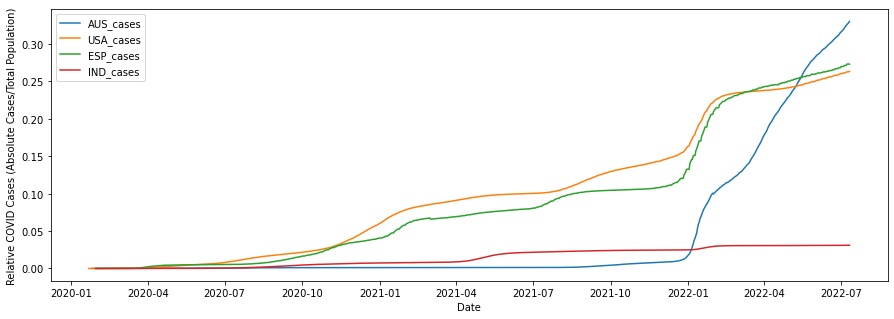

In [65]:
# Defining the size for plotting 
fig = plt.figure(figsize=(15,5))
# plot for relative covid cases for Australia
plt.plot(df["list_date_AUS"], df["list_cases_AUS"], label = "AUS_cases")
# plot for relative covid cases for USA
plt.plot(df["list_date_USA"], df["list_cases_USA"], label = "USA_cases")
# plot for relative covid cases for Spain
plt.plot(df["list_date_ESP"], df["list_cases_ESP"], label = "ESP_cases")
# plot for relative covid cases for India
plt.plot(df["list_date_IND"], df["list_cases_IND"], label = "IND_cases")

# Add X-label for date
plt.xlabel('Date')
# Add Y-label for relative covid cases 
plt.ylabel('Relative COVID Cases (Absolute Cases/Total Population)')
# Add legend
plt.legend()
# Display Plot
plt.show()

# Relative Vaccinations (Absolute Vaccination/Population Size)

In [9]:
# create an empty dictionary
dict_from_list = {}

# for loop to convert list of dict
# to dict of list
for item in json_object_vax:
	name = item['country']
	dict_from_list[name] = item

#Separating dictonary of USA from list and adding it to new list:
country_USA=dict_from_list['United States']

#Separating the list that contains the data we need from the USA dictonary:
country_USA_data=country_USA['data']

#Creating an empty dictonary to get data(date, vaccination):
dictionary_of_USA_date_vax={}

#Creating dictonary from the list:
for item in country_USA_data:
	name = item['date']
	dictionary_of_USA_date_vax[name] = item

#Creating an empty list:
inter_list_USA=[]

#Adding all the keys from data dictonary to an empty list:
for key in dictionary_of_USA_date_vax:
	inter_list_USA.append(dictionary_of_USA_date_vax[key])


#Converting list to dataframe:
pd_USA_inter=pd.DataFrame(inter_list_USA)

#Renaming the label total_vaccinations column to 'USA ratio vaccination:population' (data it holds while plotting)
pd_USA_inter = pd_USA_inter.rename(columns={'total_vaccinations':'USA_ratio_vax_pop'})

#Setting the index of the dataframe to date:
pd_USA_inter.set_index('date')

#Separating the data columns that we need for the plot (date, total_vaccinations):
pd_USA_fin= pd_USA_inter.iloc[:, [0,1]]

#Getting the total population of United Kingdom from the above requested json data:
pop_USA=json_object_cases['USA']['population']

#Dividing the vaccinated people by total population to get the ratio:
fin_USA=pd_USA_fin.copy()
fin_USA['USA_ratio_vax_pop']=fin_USA['USA_ratio_vax_pop'].div(pop_USA)

# Dashboard Creation 

In [ ]:
app = dash.Dash()
app.layout = html.Div([
    html.Label('Multi-Select Country'),
    dcc.Dropdown(id='country_drop_down',
                 options=[{
                     'label': 'Italy',
                     'value': 'Italy'
                 }, {
                     'label': 'US',
                     'value': 'US'
                 }, {
                     'label': 'Spain',
                     'value': 'Spain'
                 }, {
                     'label': 'Germany',
                     'value': 'Germany'
                 }, {
                     'label': 'Korea, South',
                     'value': 'Korea, South'
                 }],
                 value=['US', 'Germany'],
                 multi=True),
    dcc.Graph(figure=fig, id='main_window_slope')
])

In [67]:

@app.callback(Output('main_window_slope', 'figure'),
              [Input('country_drop_down', 'value')])
def update_figure(country_list):

    traces = []
    for each in country_list:
        traces.append(
            dict(x=df.date,
                 y=df[each],
                 mode='markers+lines',
                 opacity=0.9,
                 line_width=2,
                 marker_size=1,
                 name=each))

    return {
        'data':
        traces,
        'layout':
        dict(
            width=1280,
            height=720,
            xaxis_title='Time',
            yaxis_title=
            'Confirmed infected people (source johns hopkins case, log-scale)',
            xaxis={
                'tickangle': -45,
                'nticks': 20,
                'tickfont': dict(size=14, color='#7f7f7f'),
            },
            yaxis={
                'type': 'log',
                'range': '[1.1, 5.5]'
            })
    }

In [68]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
